# Chocolate Scraping with Beautiful Soup

[This](https://content.codecademy.com/courses/beautifulsoup/cacao/index.html) website contains over 1700 reviews of chocolate bars from different manufacturers.

### Turning the contents of the website table into a pandas dataframe

In [157]:

import requests 
from bs4 import BeautifulSoup, Tag
import pandas as pd 

# Get webpage content 
url = "https://content.codecademy.com/courses/beautifulsoup/cacao/index.html"
request = requests.get(url)
webpage = request.content 

# Create BeautifulSoup object 
soup = BeautifulSoup(webpage, "html.parser")

# Turn the contents of the table into a pandas dataframe 
def get_column_info(class_name: str):
  column_info = []
  for row in soup.find_all("td", attrs={"class": class_name}):
    column_info.append(row.string)
  return column_info[1:] # exclude header

class_names = ["Company", "Origin", "ReviewDate", "CocoaPercent", "CompanyLocation", "BeanType", "BroadBeanOrigin", "Rating"]
table = {}

for name in class_names:
  table[name] = get_column_info(name)

df = pd.DataFrame(table, columns=class_names)

# Convert Rating, ReviewDate and Percentage into numeric columns (currently "object" dtype)
df.ReviewDate = pd.to_numeric(df.ReviewDate) # int 
df.Rating = pd.to_numeric(df.Rating) # float


# For CocoaPercent, first remove the percent sign
df.CocoaPercent = df.CocoaPercent.str.replace("%","") 
df.CocoaPercent = pd.to_numeric(df.CocoaPercent) / 100 

# Fix typos in the names of the countries
df.CompanyLocation = df.CompanyLocation.str.replace("Eucador", "Ecuador")
df.CompanyLocation = df.CompanyLocation.str.replace("Niacragua", "Nicaragua")
df.CompanyLocation = df.CompanyLocation.str.replace("Domincan Republic", "Dominican Republic")
df.BroadBeanOrigin = df.BroadBeanOrigin.str.replace("Domincan Republic", "Dominican Republic")
# Amsterdam is not a country 
df.CompanyLocation = df.CompanyLocation.str.replace("Amsterdam", "Netherlands")


# Save the data to avoid having to make requests again 
df.to_csv("chocolate_ratings.csv", sep="|")

### Ratings distribution

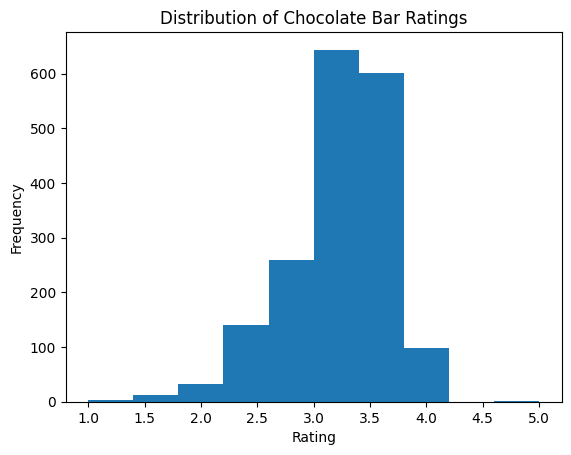

In [197]:
import pandas as pd
import matplotlib.pyplot as plt 

df = pd.read_csv("chocolate_ratings.csv", sep="|", index_col=0)

plt.hist(df.Rating) # left skewed 
plt.ylabel("Frequency")
plt.xlabel("Rating")
plt.title("Distribution of Chocolate Bar Ratings")
plt.show()

### Top rated chocolate manufacturer

In [100]:
company_mean_rating = df.groupby("Company").Rating.mean().sort_values(ascending=False)
print(company_mean_rating.head())

Company
Tobago Estate (Pralus)                  4.000000
Heirloom Cacao Preservation (Zokoko)    3.875000
Ocelot                                  3.875000
Amedei                                  3.846154
Matale                                  3.812500
Name: Rating, dtype: float64


### Top rated country manufacturers 

In [102]:
country_mean_rating = df.groupby("CompanyLocation").Rating.mean().sort_values(ascending=False).reset_index()
print(country_mean_rating[:5])

  CompanyLocation    Rating
0           Chile  3.750000
1     Philippines  3.500000
2     Netherlands  3.500000
3         Iceland  3.416667
4         Vietnam  3.409091


### Relationship between cocoa amount and rating 

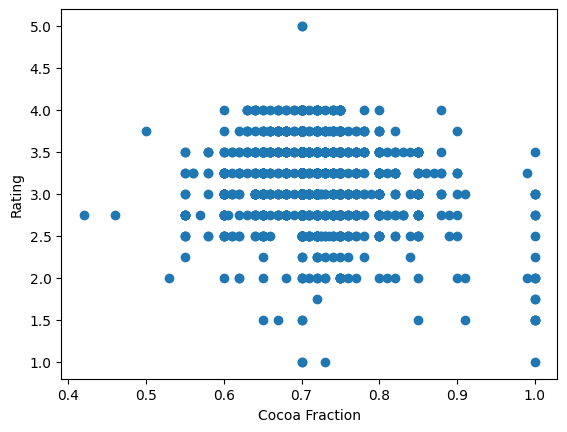

In [88]:
plt.scatter(df.CocoaPercent, df.Rating)
plt.xlabel("Cocoa Fraction")
plt.ylabel("Rating")
plt.show()

### Top rated bean origins 
(Excluding blends)

In [206]:
import re 

# Turn the entire column into string 
df.BroadBeanOrigin = df.BroadBeanOrigin.astype(str)

# Remove beans coming from more than two countries, as well as unspecified origins (continent name only)
pattern = r"[&(),-/]|\xa0|West Africa|South America|nan"
def find_match(input_string: str):
  return True if re.search(pattern, input_string) else False

# This is True if the chocolate is made of a blend of several beans 
mask = df.BroadBeanOrigin.apply(find_match)

new_df = df[~mask].reset_index(drop=True)
# Get relevant columns, drop NaNs, reset index
origin_rating = new_df[['BroadBeanOrigin', 'Rating']].dropna()

# Top Rated Bean Origins
origin_mean_rating = origin_rating.groupby("BroadBeanOrigin").Rating.mean().sort_values(ascending=False)

print(origin_mean_rating.head())

BroadBeanOrigin
Tobago             3.625000
Solomon Islands    3.437500
Haiti              3.388889
Honduras           3.350000
Congo              3.325000
Name: Rating, dtype: float64
